In [91]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [92]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML, Image
from ipywidgets import interact,Dropdown,IntSlider,FloatRangeSlider, FloatSlider, RadioButtons
rc('animation', html='html5')

In [93]:
colorsgallery  = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
            (240,128,128),(233,150,122),(250,128,114),(255,160,122),
            (50,205,50),(144,238,144),(152,251,152),(143,188,143),
            (0,250,154),(0,255,127),(102,205,170),(60,179,113),
            (70,130,180),(100,149,237),(0,191,255),(30,144,255),
            (173,216,230),(135,206,235),(199,21,133),(219,112,147),
            (255,20,147),(255,105,180),(255,182,193),(255,192,203),(250,235,215)])/255.

In [94]:
cd /home/xupeng/projects/membrane/

/home/xupeng/projects/membrane


In [95]:
ls data/segment/

em_s009.png  em_s030.png  em_s051.png   seg_s020.png  seg_s041.png
em_s010.png  em_s031.png  em_s052.png   seg_s021.png  seg_s042.png
em_s011.png  em_s032.png  em_s053.png   seg_s022.png  seg_s043.png
em_s012.png  em_s033.png  em_s054.png   seg_s023.png  seg_s044.png
em_s013.png  em_s034.png  em_s055.png   seg_s024.png  seg_s045.png
em_s014.png  em_s035.png  em_s056.png   seg_s025.png  seg_s046.png
em_s015.png  em_s036.png  em_s057.png   seg_s026.png  seg_s047.png
em_s016.png  em_s037.png  em_s058.png   seg_s027.png  seg_s048.png
em_s017.png  em_s038.png  em_s059.png   seg_s028.png  seg_s049.png
em_s018.png  em_s039.png  em_s060.png   seg_s029.png  seg_s050.png
em_s019.png  em_s040.png  seg_s009.png  seg_s030.png  seg_s051.png
em_s020.png  em_s041.png  seg_s010.png  seg_s031.png  seg_s052.png
em_s021.png  em_s042.png  seg_s011.png  seg_s032.png  seg_s053.png
em_s022.png  em_s043.png  seg_s012.png  seg_s033.png  seg_s054.png
em_s023.png  em_s044.png  seg_s013.png  seg_s034.png  seg_s055

In [96]:
segdata = {}
for i in range(52):
    segdata[i] = scipy.misc.imread('data/segment/seg_s0'+'{0:02}'.format(i+9)+'.png')

In [97]:
emdata = {}
for i in range(52):
    emdata[i] = scipy.misc.imread('data/segment/em_s0'+'{0:02}'.format(i+9)+'.png')

In [98]:
uniqueind = np.unique(segdata[0].reshape(-1,3),axis=0)

In [99]:
uniqueind1 = np.unique(segdata[26].reshape(-1,3),axis=0)

In [100]:
np.unique(np.sum(segdata[0].reshape(-1,3),axis=1),return_counts=True)

(array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
         39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  75,  78,  81,
         84,  87,  90,  93,  96,  99, 102, 105, 108, 114, 117, 120, 123,
        126, 129, 132], dtype=uint64),
 array([858585,   2605,   4547,   4446,   4301,    704,   1963,   2075,
          5097,   3217,   2528,   5761,   2075,   2744,   6314,   3104,
          3749,   5369,   2322,   2277,   4489,    181,  27282,   8369,
           305,  11399,  17769,   5526,   1666,   3509,   3673,   1839,
          3450,   1458,   3489,    740,   1690,   3513,   1937,   4230,
          3379,   2744]))

## preprocess
- windowsize
- remove schwann cell
- find contour
- store to hdf5 as image and mask

In [101]:
def transform_rgb(img):
    num = np.unique(img.reshape(-1,3),axis=0).shape[0]
    #print (num)
    #rgbarr = np.ndarray([num*3])
    #for i in range(num*3):
      #  rgbarr[i] = np.random.uniform(0,1)
    #rgbarr = rgbarr.reshape(-1,3)
    image = np.zeros([img.shape[0]*img.shape[1],3])
    sumimg = np.sum(img.reshape(-1,3),axis=1)
    uniqueind = np.unique(img.reshape(-1,3),axis=0)
    for i in np.arange(0,num-1):
        image[sumimg==3*(uniqueind[i][0]+1)] = colorsgallery[i]
    #print (sumimg.shape)
    image[sumimg==0] = [1,1,1]
    return image.reshape(img.shape[0],img.shape[1],3)

In [102]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[0])
sns.set_style(styles[0])

## cutting window
find the min, max position!

In [103]:
def find_bounding(data):
    xmin = np.sort(np.where(data[:,:,0]!=0)[0])[0]
    xmax = np.sort(np.where(data[:,:,0]!=0)[0])[-1]
    ymin = np.sort(np.where(data[:,:,0]!=0)[1])[0]
    ymax = np.sort(np.where(data[:,:,0]!=0)[1])[-1]
    return xmin, xmax, ymin, ymax

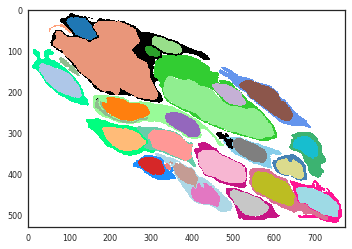

In [84]:
i = 0
j = 0
xmin, xmax, ymin, ymax = find_bounding(segdata[i*2+j])
imshow(transform_rgb(segdata[i*2+j][(xmin-10): (xmax+10), (ymin-10): (ymax+10)]))

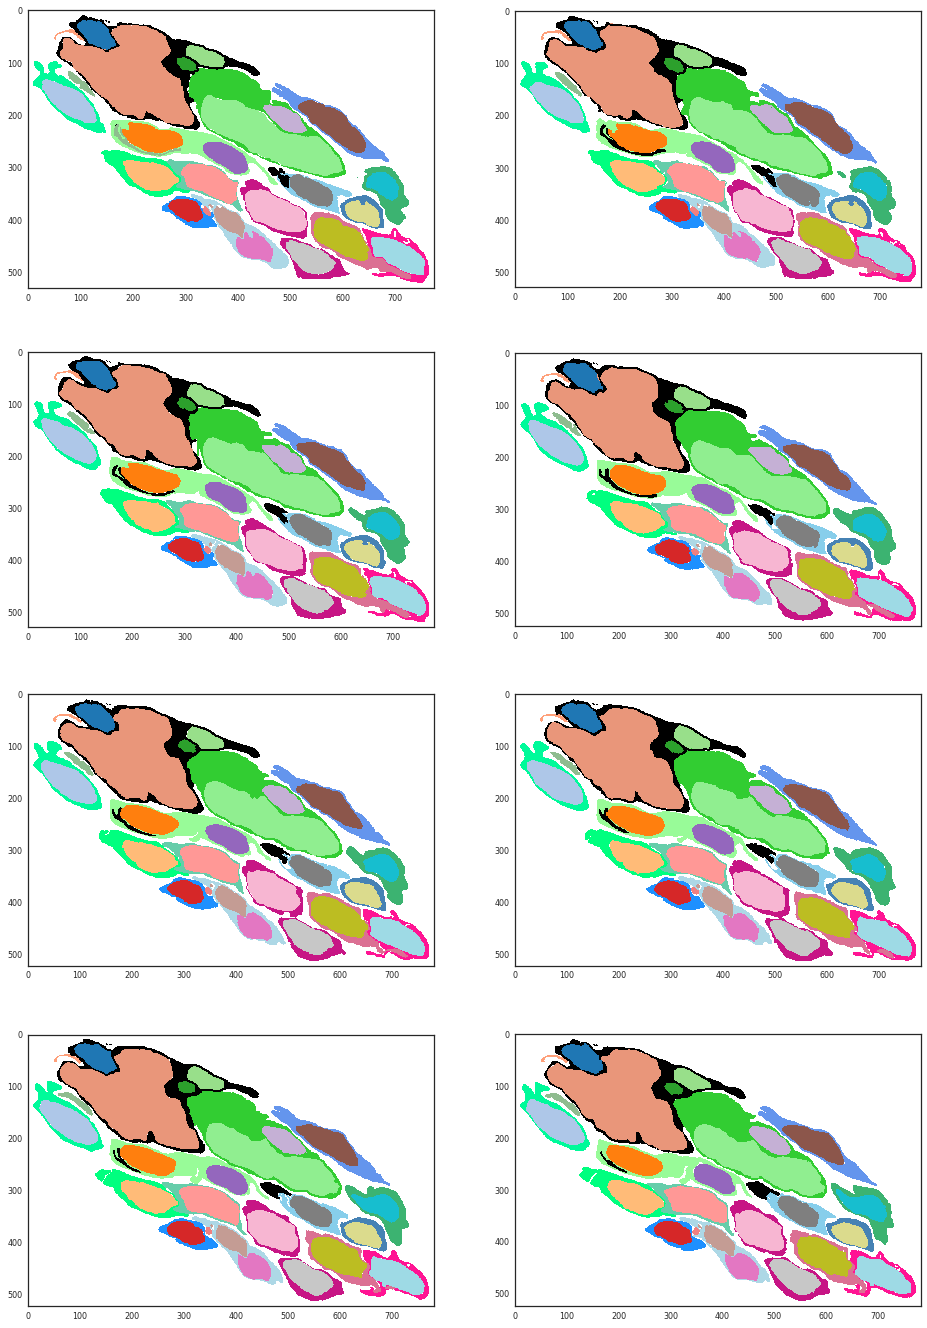

In [104]:
row = 4
fig,ax=plt.subplots(row,2,figsize=(16,6*row))
for i in range(row):
    for j in range(2):
        xmin, xmax, ymin, ymax = find_bounding(segdata[i*2+j])
        ax[i,j].imshow(transform_rgb(segdata[i*2+j][(xmin-10): (xmax+10), (ymin-10): (ymax+10)]))

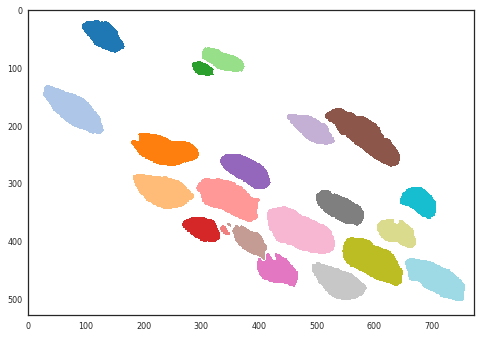

In [105]:
def transform_rgb_(img,uniqueind):
    num = np.unique(img.reshape(-1,3),axis=0).shape[0]
    #print (num)
    #rgbarr = np.ndarray([num*3])
    #for i in range(num*3):
      #  rgbarr[i] = np.random.uniform(0,1)
    #rgbarr = rgbarr.reshape(-1,3)
    image = np.zeros([img.shape[0]*img.shape[1],3])
    sumimg = np.sum(img.reshape(-1,3),axis=1)
    #uniqueind = np.unique(img.reshape(-1,3),axis=0)
    #print (uniqueind)
    for i in np.arange(0,num):
        #print (uniqueind.shape)
        if i <22:
            image[sumimg==3*(uniqueind[:22,:][i][0]+1)] = colorsgallery[i]
            #print (uniqueind[:22,:][i][0]+1)
        else:
            image[sumimg==3*(uniqueind[i][0])] = [1,1,1]
            
    #print (sumimg.shape)
    image[sumimg==0] = [1,1,1]
    return image.reshape(img.shape[0],img.shape[1],3)
xmin, xmax, ymin, ymax = find_bounding(segdata[0])
fig,ax=plt.subplots(1,figsize=(8,6))
imshow(transform_rgb_(segdata[0][(xmin-10): (xmax+10), (ymin-10): (ymax+10)],uniqueind))

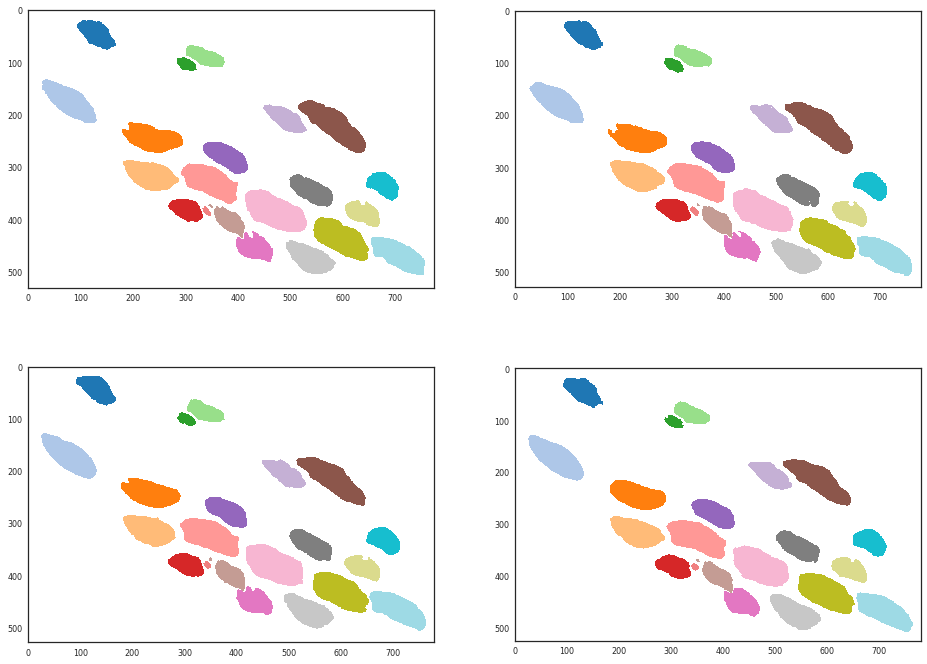

In [106]:
row = 2
fig,ax=plt.subplots(row,2,figsize=(16,6*row))
for i in range(row):
    for j in range(2):
        xmin, xmax, ymin, ymax = find_bounding(segdata[i*2+j])
        if i <13:       
            ax[i,j].imshow(transform_rgb_(segdata[i*2+j][(xmin-10): (xmax+10), (ymin-10): (ymax+10)],uniqueind))
        else:
            ax[i,j].imshow(transform_rgb_(segdata[i*2+j][(xmin-10): (xmax+10), (ymin-10): (ymax+10)],uniqueind1))

In [14]:
# not perfectly remove all schwann cell, find each unique ind!

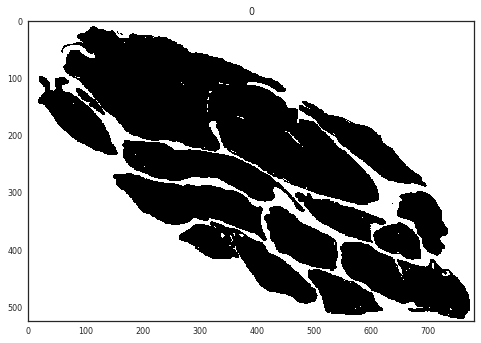

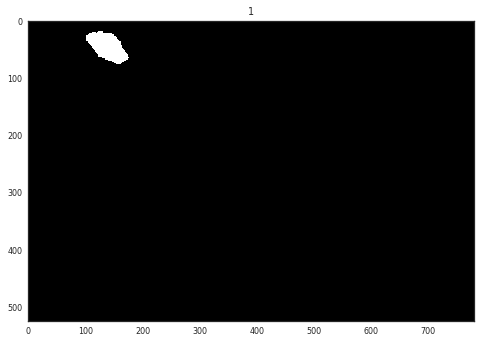

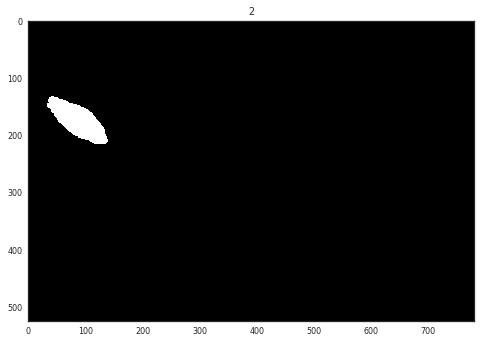

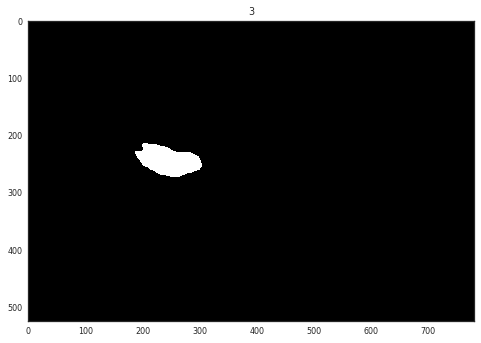

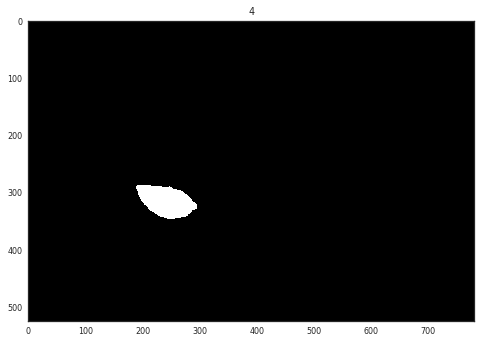

In [107]:
for i in range(5):
    zeroarr = np.zeros(segdata[0].shape)
    fig,ax=plt.subplots(1,figsize=(8,6))
    zeroarr[np.where(segdata[0] ==i)] =1
    ax.set_title(str(i))
    ax.imshow(zeroarr[(xmin-10): (xmax+10), (ymin-10): (ymax+10)])

In [108]:
def remove_schwann(img,uniqueind):
    num = np.unique(img.reshape(-1,3),axis=0).shape[0]
    #print (num)
    #rgbarr = np.ndarray([num*3])
    #for i in range(num*3):
      #  rgbarr[i] = np.random.uniform(0,1)
    #rgbarr = rgbarr.reshape(-1,3)
    image = np.zeros([img.shape[0]*img.shape[1]])
    sumimg = np.sum(img.reshape(-1,3),axis=1)
    #uniqueind = np.unique(img.reshape(-1,3),axis=0)
    #print (uniqueind)
    for i in np.arange(0,num):
        #print (uniqueind.shape)
        if i <22:
            image[sumimg==3*(uniqueind[:22,:][i][0]+1)] = 100
            #print (uniqueind[:22,:][i][0]+1)
        else:
            image[sumimg==3*(uniqueind[i][0])] = 0
            
    #print (sumimg.shape)
    image[image!=100] =0
    image[image==100] =1
    return image.reshape(img.shape[0],img.shape[1])

In [109]:
removedimg = {}
for i in range(51):
    xmin, xmax, ymin, ymax = find_bounding(segdata[i])
    if i <26:       
        removedimg[i] = remove_schwann(segdata[i][(xmin-10): (xmax+10), (ymin-10): (ymax+10)],uniqueind)
    else:
        removedimg[i] = remove_schwann(segdata[i][(xmin-10): (xmax+10), (ymin-10): (ymax+10)],uniqueind1)

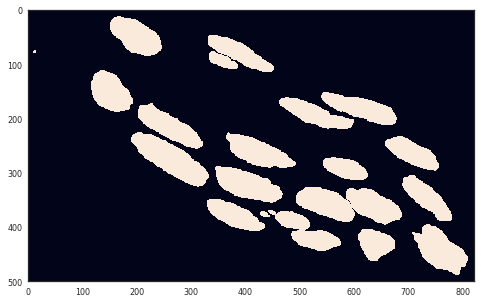

In [125]:
fig,ax=plt.subplots(1,figsize=(8,6))
imshow(removedimg[i])

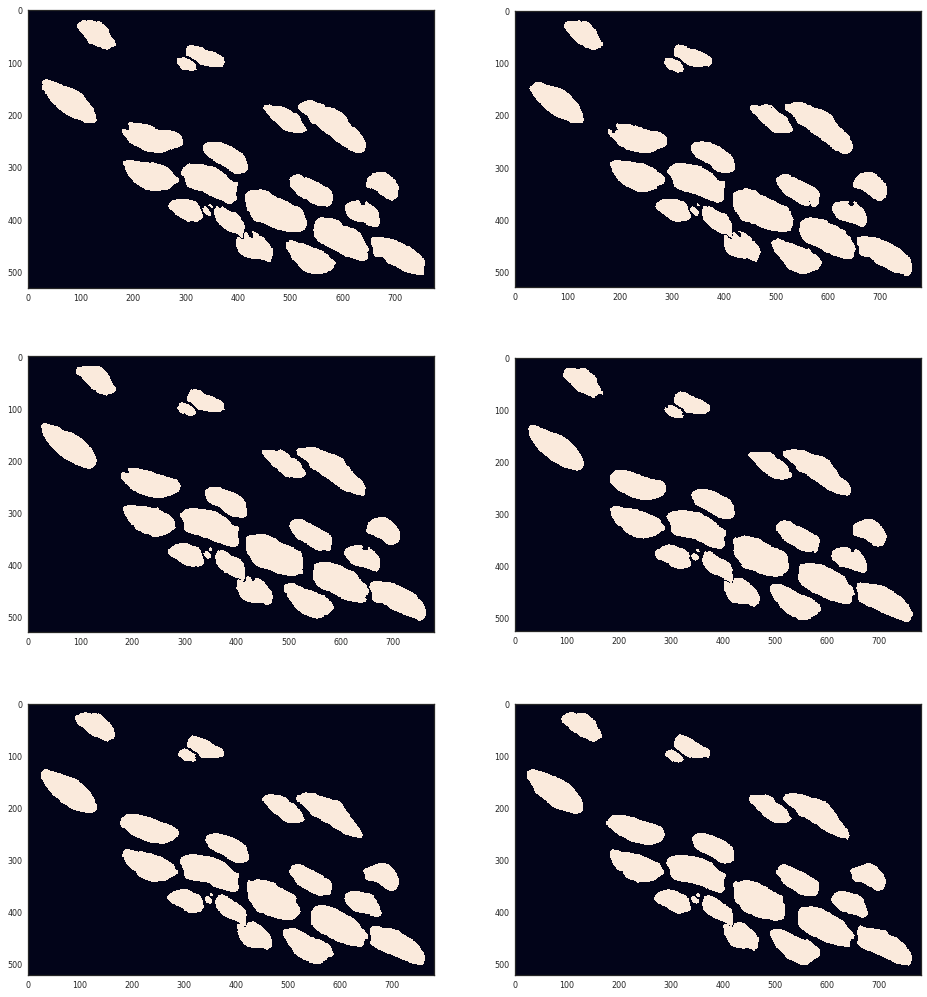

In [110]:
row = 3
fig,ax=plt.subplots(row,2,figsize=(16,6*row))
for i in range(row):
    for j in range(2):
        ax[i,j].imshow(removedimg[i*2+j])

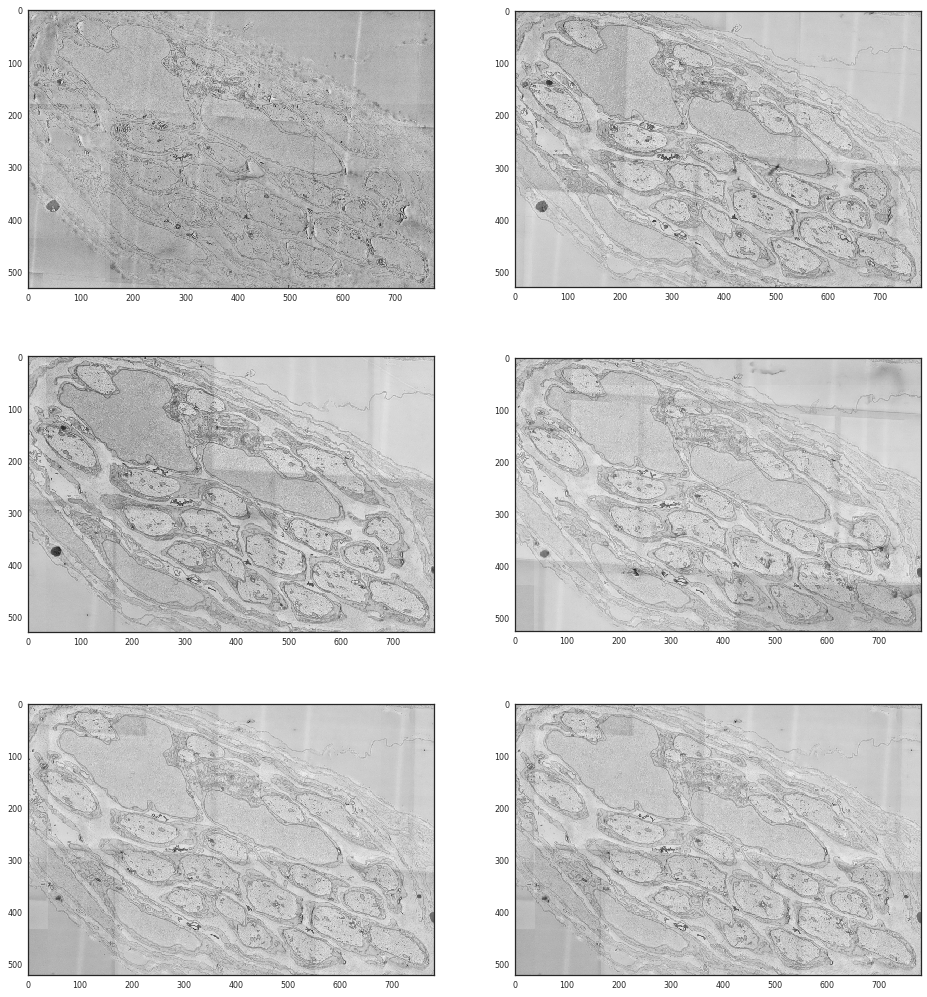

In [111]:
row = 3
fig,ax=plt.subplots(row,2,figsize=(16,6*row))
for i in range(row):
    for j in range(2):
        xmin, xmax, ymin, ymax = find_bounding(segdata[i*2+j])
        ax[i,j].imshow(emdata[i*2+j][(xmin-10): (xmax+10), (ymin-10): (ymax+10)],cmap='gray')

In [112]:
emimg = {}
for i in range(51):
    xmin, xmax, ymin, ymax = find_bounding(segdata[i])      
    emimg[i] = emdata[i][(xmin-10): (xmax+10), (ymin-10): (ymax+10)]

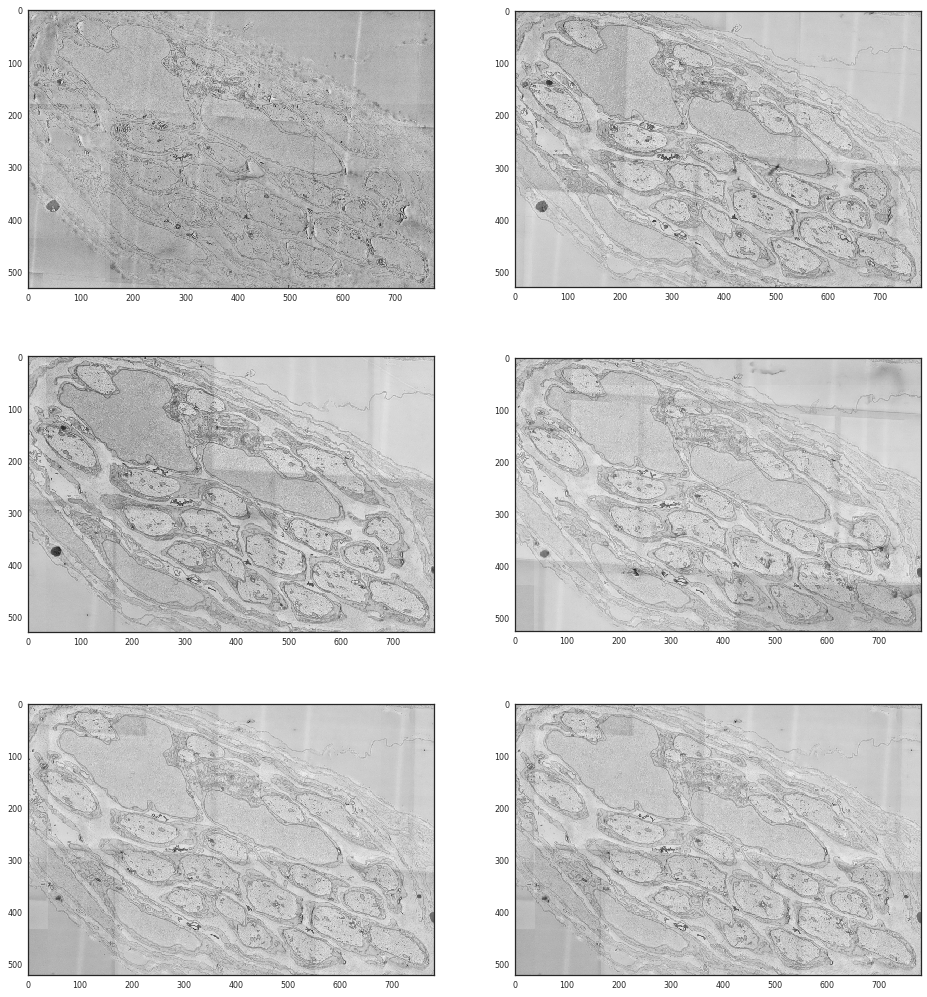

In [113]:
row = 3
fig,ax=plt.subplots(row,2,figsize=(16,6*row))
for i in range(row):
    for j in range(2):
        ax[i,j].imshow(emimg[i*2+j],cmap='gray')

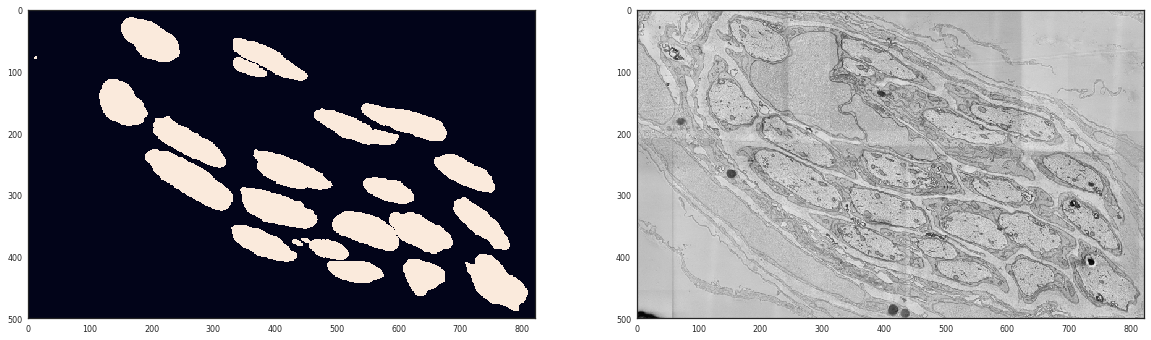

In [137]:
fig,ax=plt.subplots(1,2,figsize=(20,16))
ax[0].imshow(removedimg[50])
ax[1].imshow(emimg[50])

In [18]:
import cv2

In [33]:
ret,thresh = cv2.threshold(grayimg,0,255,0)
image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img=cv2.drawContours(image,contours,-1,(0,255,0),3)

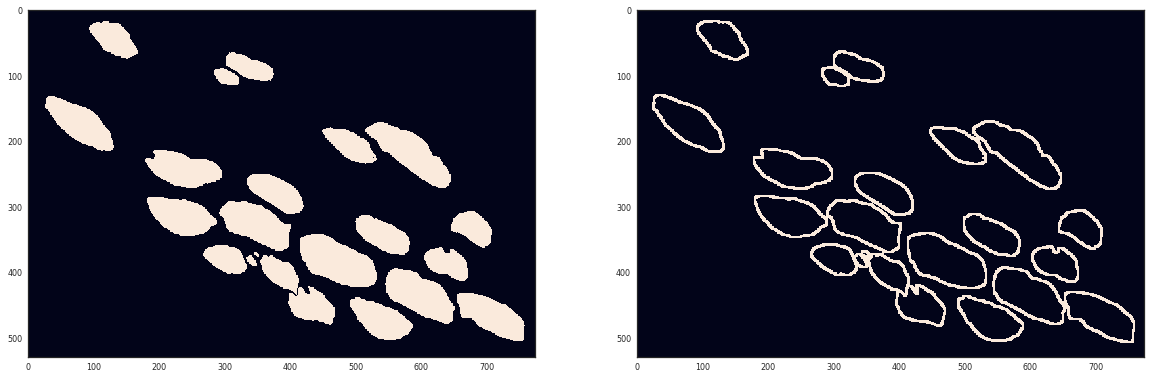

In [47]:
grayimg = np.uint8(removedimg[0] * 255)
fig,ax=plt.subplots(1,2,figsize=(20,16))
open0 = cv2.erode(grayimg, None, iterations = 1)
open1 = cv2.dilate(open0, None, iterations = 4)
ax[0].imshow(grayimg)
ax[1].imshow(open1-open0)

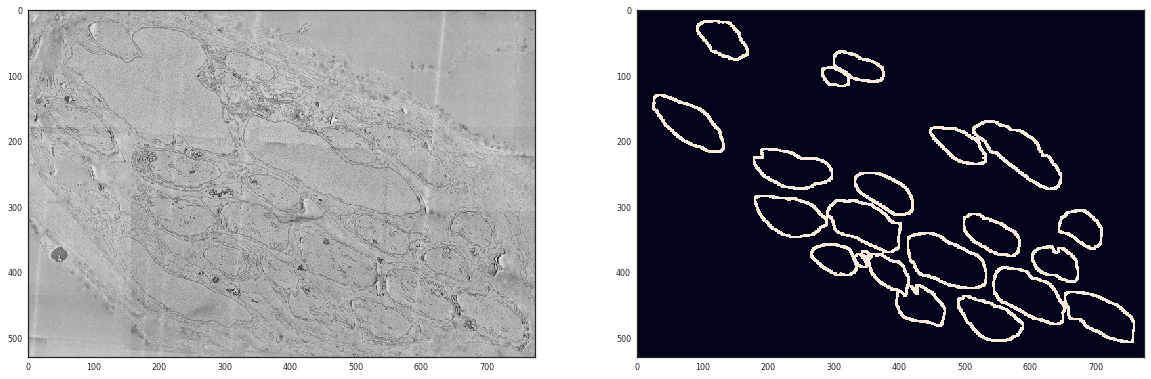

In [50]:
#grayimg = np.uint8(removedimg[0] * 255)
fig,ax=plt.subplots(1,2,figsize=(20,16))
open0 = cv2.erode(removedimg[0], None, iterations = 1)
open1 = cv2.dilate(open0, None, iterations = 4)
ax[0].imshow(emimg[0])
ax[1].imshow(open1-open0)

In [114]:
for i in range(51):
    emimg[i] = emimg[i][:,:,0]

In [115]:
binary_mask = {}
for i in range(51):
    open0 = cv2.erode(removedimg[i], None, iterations = 1)
    open1 = cv2.dilate(open0, None, iterations = 4)
    binary_mask[i] = open1-open0

In [116]:
(530,835)

(530, 835)

In [117]:
i = 0
xnan = 530 - emimg[i].shape[0]
ynan = 835 - emimg[i].shape[1]
xleft = int(xnan/2)
xright = int(xnan - xleft)
yleft = int(ynan/2)
yright = int(ynan - yleft)

In [118]:
paddedem = np.ndarray([51,530, 835])
paddedmask = np.ndarray([51,530, 835])
for i in range(51):
    xnan = 530 - emimg[i].shape[0]
    ynan = 835 - emimg[i].shape[1]
    xleft = int(xnan/2)
    xright = int(xnan - xleft)
    yleft = int(ynan/2)
    yright = int(ynan - yleft)
    paddedem[i] = np.pad(emimg[i], ((xleft,xright),(yleft,yright)), 'reflect')
    paddedmask[i] = np.pad(binary_mask[i], ((xleft,xright),(yleft,yright)), 'reflect')

In [ ]:
row = 4
fig,ax=plt.subplots(row,2,figsize=(16,6*row))
for i in range(row):
    for j in range(2):
        ax[i,0].imshow(paddedem[i],cmap='gray')
        ax[i,1].imshow(paddedmask[i],cmap='gray')

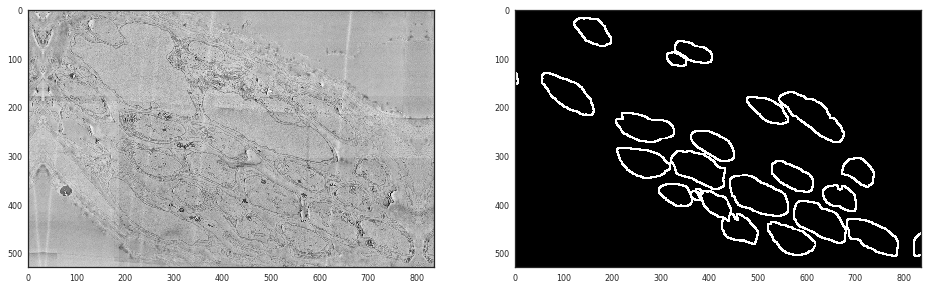

In [84]:
fig,ax=plt.subplots(1,2,figsize=(16,6*1))
ax[0].imshow(paddedem[0],cmap='gray')
ax[1].imshow(paddedmask[0],cmap='gray')

In [86]:
np.unique(paddedem[0])

array([ 21.,  22.,  24.,  25.,  26.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 17

In [89]:
with h5py.File('data/train_set/em_51') as f:
    f.create_dataset('main',data= paddedem,dtype = uint8)
with h5py.File('data/train_set/mask_51') as f:
    f.create_dataset('main',data= paddedmask,dtype =uint8)